In [8]:
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from tensorflow.keras.utils import to_categorical

import numpy as np
import nltk
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm as log_progress

In [5]:
#load and clean data
raw = open("data.txt", "r")

lines = []
for line in raw:
    if str(line) != '\n':
        lines.append(str(line).lower())

#putting the entirety of the input data into one string
text = ""
for line in lines:
    text += line
tokenized = nltk.word_tokenize(text)

#converting the text into numbers to be processed by the embedding layer of the model
words = [] #one of each word in tokenized will be in here
filtering = lambda x : not x in words #for finding if the word should be added to the words array
find = lambda x : words.index(x) if x in words else -1 #convert each word into a number. -1 means that the item isn't in the vocabulary

for word in tokenized:
    if filtering(word):
        words.append(word)

#x data is every single word in the data set, in order
#y data is every single word that comes after the corresponding x value
x = []
y = []
for i in range(len(tokenized)):
    x.append(find(tokenized[i]))
    if i+1 < len(tokenized):
        y.append(find(tokenized[i+1]))
    else:
        y.append(find("."))

x = np.asarray(x)
y = np.asarray(y)
y = to_categorical(y)

print(x.shape)
print(y.shape)

vocab_size = len(words) + 1

(21078,)
(21078, 3297)


In [6]:
#create and compile model
model = Sequential()

model.add(Embedding(vocab_size, 32, input_length=(1))) #embedding: size of vocabulary, dimension of each value
model.add(LSTM(20))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 32)             105536    
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                4240      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                672       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3297)              108801    
Total params: 219,249
Trainable params: 219,249
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
2087/2087 [==============================] - 20s 7ms/step - loss: 6.3650 - accuracy: 0.0849 - val_loss: 6.7198 - val_accuracy: 0.0900
Epoch 2/20
2087/2087 [==============================] - 13s 6ms/step - loss: 5.9973 - accuracy: 0.0855 - val_loss: 7.0228 - val_accuracy: 0.0900
Epoch 3/20
2087/2087 [==============================] - 12s 6ms/step - loss: 5.8480 - accuracy: 0.0955 - val_loss: 7.1211 - val_accuracy: 0.0995
Epoch 4/20
2087/2087 [==============================] - 13s 6ms/step - loss: 5.6808 - accuracy: 0.1096 - val_loss: 7.2868 - val_accuracy: 0.0900
Epoch 5/20
2087/2087 [==============================] - 13s 6ms/step - loss: 5.5173 - accuracy: 0.1118 - val_loss: 7.5241 - val_accuracy: 0.0995
Epoch 6/20
2087/2087 [==============================] - 13s 6ms/step - loss: 5.3782 - accuracy: 0.1221 - val_loss: 7.7538 - val_accuracy: 0.0948
Epoch 7/20
2087/2087 [==============================] - 13s 6ms/step - loss: 5.2614 - accuracy: 0.1355 - val_loss: 7.9175 - val_ac

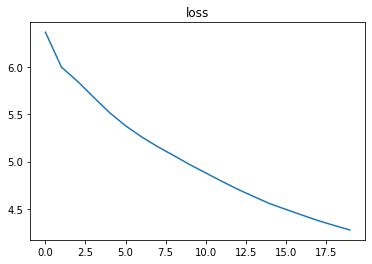

In [7]:
#train model
hist = model.fit(x, y, epochs=20, verbose=1, batch_size=10, validation_split=0.01)
plt.title("loss")
plt.plot(hist.history['loss'])
model.save("shakespear2.0.h5")

In [ ]:
#test model
sample_length = 100
model = load_model("shakespear2.0.h5")

root = random.choice(words)
output = ""

for i in log_progress(range(sample_length)):
    num = find(root)
    pred = model.predict([num])
    next_word = np.random.choice(len(pred[0]), p=pred[0])
    output += words[next_word] + " "
    root = words[pred.argmax()] #setting the next word

print(output)